In [1]:
exp_no = 0

In [2]:
import os
import sys
import git
import pathlib

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

PROJ_ROOT_PATH = pathlib.Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
PROJ_ROOT =  str(PROJ_ROOT_PATH)
if PROJ_ROOT not in sys.path:
    sys.path.append(PROJ_ROOT)

print(f"Project Root Directory: {PROJ_ROOT}")

Project Root Directory: /repos/drl_csense


In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import gymnasium as gym

In [6]:
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy

In [7]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [8]:
env_id = "BreakoutNoFrameskip-v4"
exp_tag = "vanilla"
exp_name = f"{env_id}--{exp_tag}"

In [9]:
logfolder_root = pathlib.Path(PROJ_ROOT_PATH / "logging")

# Directory to save all training statistics
log_dir = pathlib.Path(logfolder_root / exp_name)
os.makedirs(log_dir, exist_ok=True)

# Directory to save gif animations
gif_dir = pathlib.Path(log_dir / "gifs" / exp_name)
os.makedirs(gif_dir, exist_ok=True)

# Directory to save models
models_dir = pathlib.Path(PROJ_ROOT_PATH / "models" / exp_name)
os.makedirs(models_dir, exist_ok=True)

In [10]:
# The different number of processes that will be used
NUM_ENVS = 16
TRAIN_STEPS = 5E7
# Number of episodes for evaluation
ALGO = A2C

In [11]:
mother_seed = 2023

In [12]:
# for experiment in range(NUM_EXPERIMENTS):
for experiment in [exp_no]:
    print("-------")
    print(f"RUN: {experiment}")
    # Log directory for each run of the experiment
    run_log_dir = f"{log_dir}/run_{experiment}"

    # Create the callback: check every 1000 steps
    callback = SaveOnBestTrainingRewardCallback(check_freq=1E4, 
                                                log_dir=run_log_dir,
                                                verbose=0)
    
    # Make vector environment
    env = make_atari_env(env_id,
                         n_envs=NUM_ENVS,
                         monitor_dir=run_log_dir,
                         seed=mother_seed+experiment)
    
    # Frame-stacking with 4 frames
    env = VecFrameStack(env, n_stack=4)

    # Create RL model
    model = A2C("CnnPolicy", env, verbose=0)

    # Train the agent
    model.learn(total_timesteps=TRAIN_STEPS, 
                progress_bar=True, 
                callback=callback)

    # Save the final agent
    model.save(f"{models_dir}/{exp_name}-run_{experiment}")

-------
RUN: 0


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Output()

In [13]:
# Visualizing Results

In [14]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")

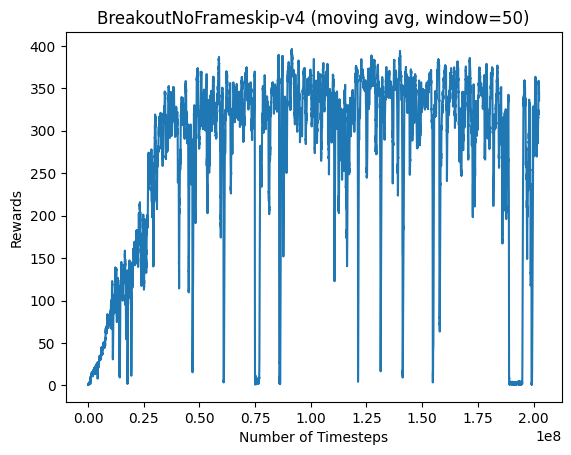

In [15]:
fig = plt.figure()
plt.xlabel("Number of Timesteps")
plt.ylabel("Rewards")
title = env_id
plt.title(title + " (moving avg, window=50)")
# for experiment in range(NUM_EXPERIMENTS):
for experiment in [exp_no]:
    run_log_dir = f"{log_dir}/run_{experiment}"
    x, y = ts2xy(load_results(run_log_dir), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]    
    plt.plot(x, y)  
plt.show()    